In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

In [2]:
os.chdir(os.getcwd()+'./new/')

In [3]:
SVI = pd.read_csv("./Google-Trends.csv") 
WIKI = pd.read_csv("./wikishark-chart.csv", index_col="DateTime", parse_dates=True) 

GP = pd.read_csv("./gold-price.csv",  index_col="Date", parse_dates=True)
USD_CNY = pd.read_csv("./usd-cny.csv",  index_col="Date", parse_dates=True)

BPI = pd.read_csv("./Bitcoin-Price.csv",  index_col="Date", parse_dates=True)
HASH = pd.read_csv("./hash-rate.csv",  index_col="Timestamp", parse_dates=True)
MINE_DIFF = pd.read_csv("./difficulty.csv",  index_col="Timestamp", parse_dates=True)
MINE_REV = pd.read_csv("./miners-revenue.csv",  index_col="Timestamp", parse_dates=True)
BTC_Trans = pd.read_csv("./n-transactions.csv", index_col="Timestamp", parse_dates=True)
COST_PER_TRANS = pd.read_csv("./cost-per-transaction.csv", index_col="Timestamp", parse_dates=True)


In [4]:
# Modifying Wiki Data: Filter to only include WIKI one month
start_date = '2021-11-14'
end_date = '2021-12-12'

mask = (WIKI.index >= start_date) & (WIKI.index <= end_date)
WIKI_SVI = WIKI.loc[mask]
WIKI_SVI.rename(columns={'Bitcoin[en]': 'wiki'}, inplace=True)

C:\Users\dell-2019\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [5]:
SVI.rename(columns={'Category: All categories': 'svi'}, inplace=True)
svi_df = SVI.iloc[1:, :]
svi_df.index = pd.to_datetime(svi_df.index)
svi_df.rename_axis('Date', inplace=True)

In [6]:
BPI.rename(columns={'Closing Price (USD)': 'close',
           '24h Open (USD)': 'open', '24h High (USD)': 'high', '24h Low (USD)': 'low'}, inplace=True)
BPI.drop(['Currency'], axis=1, inplace=True)


In [ ]:
# Drop nan values
GP.dropna(axis=1, how="all", inplace=True)
GP.drop(['Open','High','Low'], axis=1, inplace=True)
GP.rename(columns={'Close': 'gold price'}, inplace=True)

In [ ]:
# Modifying Transactions Data: Filter to only include transactions in first week of November 2021
start_date = '2021-11-14'
end_date = '2021-12-12'

mask = (BTC_Trans.index >= start_date) & (BTC_Trans.index <= end_date)
btc_num_t_df = BTC_Trans.loc[mask]

In [ ]:
vis= f"""
SVI : {svi_df.index.size}
WIKI : {WIKI_SVI.index.size}
GP  : {GP.index.size}
BPI : {HASH.index.size}
HASH : {BPI.index.size}
MINE_DIFF : {MINE_DIFF.index.size}
COST_PER_TRANS : {COST_PER_TRANS.index.size}
MINE_REV : {MINE_REV.index.size}
Num. transactions : {btc_num_t_df.index.size}"""

print(vis)

In [ ]:
dataframe = pd.concat([BPI, svi_df, WIKI_SVI, GP, btc_num_t_df,
                      COST_PER_TRANS, HASH, MINE_DIFF, MINE_REV], axis=1)
# dataframe.fillna(0, inplace=True)
dataframe.dropna(axis=0, how='any', inplace=True)
dataframe["svi"] = dataframe["svi"].astype(str).astype(int)
dataframe.to_csv("../merged_df.csv")
dataframe

In [ ]:
dataframe.info()
dataframe.shape
dataframe.describe()

In [43]:
cmap = cmap = sns.diverging_palette(5, 250, as_cmap=True)

In [44]:
corr = dataframe.corr()


corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '100px', 'font-size': '15pt'})\
    .set_precision(2)

,close,open,high,low,svi,wiki,gold price,n-transactions,cost-per-transaction,hash-rate,difficulty,miners-revenue
close,1,0.91,0.94,0.96,-0.39,-0.17,0.7,0.016,0.35,-0.44,0.59,0.53
open,0.91,1,0.99,0.89,-0.16,-0.025,0.71,0.15,0.25,-0.4,0.63,0.56
high,0.94,0.99,1,0.91,-0.23,-0.099,0.7,0.12,0.24,-0.47,0.62,0.52
low,0.96,0.89,0.91,1,-0.52,-0.21,0.67,0.11,0.27,-0.45,0.59,0.52
svi,-0.39,-0.16,-0.23,-0.52,1,0.6,0.0088,0.13,-0.21,0.27,-0.088,-0.11
wiki,-0.17,-0.025,-0.099,-0.21,0.6,1,-0.044,0.57,-0.45,0.2,0.029,0.029
gold price,0.7,0.71,0.7,0.67,0.0088,-0.044,1,-0.16,0.45,-0.15,0.66,0.52
n-transactions,0.016,0.15,0.12,0.11,0.13,0.57,-0.16,1,-0.76,-0.052,0.086,0.061
cost-per-transaction,0.35,0.25,0.24,0.27,-0.21,-0.45,0.45,-0.76,1,0.34,-0.025,0.6
hash-rate,-0.44,-0.4,-0.47,-0.45,0.27,0.2,-0.15,-0.052,0.34,1,-0.49,0.49


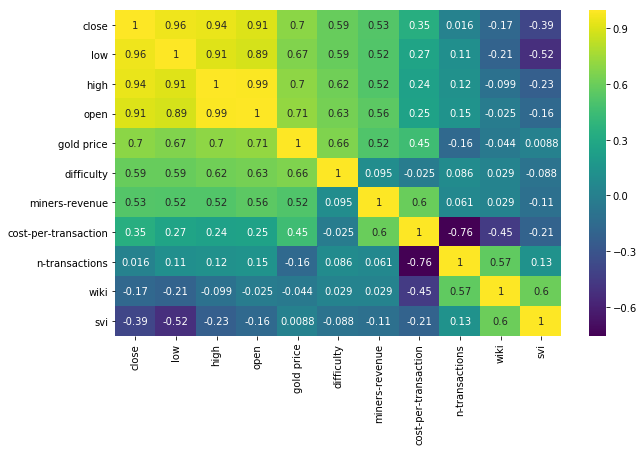

In [45]:
#Close price correlation matrix
k = 11  # number of variables for heatmap
cols = dataframe.corr().nlargest(k, 'close')['close'].index
cm = dataframe[cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='viridis')


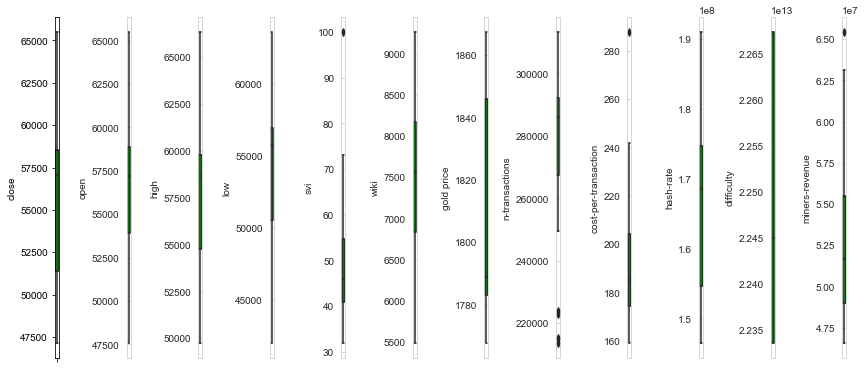

In [46]:
# check for outliers
l = dataframe.columns.values
number_of_columns = 12
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns, 5*number_of_rows))
for i in range(0, len(l)):
    plt.subplot(number_of_rows + 1, number_of_columns, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(dataframe[l[i]], color='green', orient='v')

plt.tight_layout()


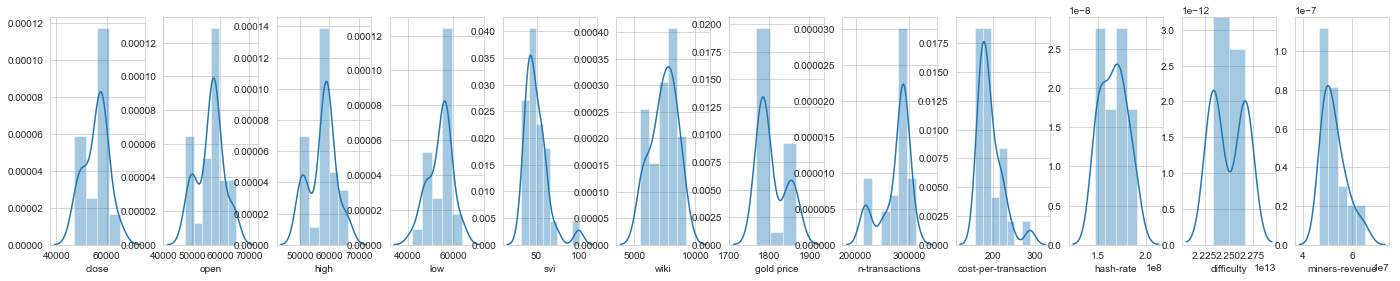

In [47]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    try:
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.distplot(dataframe[l[i]],kde=True) 
    except TypeError as e:
        print("Error in subplot", i, e)

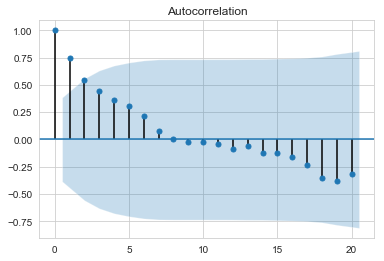

In [48]:
sm.graphics.tsa.plot_acf(dataframe['close'], lags=20);

In [49]:
X = dataframe['close'].values

result = ts.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.387054
p-value: 0.588467
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633
